In [137]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First, let's prepare the data

In [2]:
# Loading data sets
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

In [3]:
print(f'There are {len(sss_batchA)} rows in the Batch A')

There are 5176 rows in the Batch A


Remove duplicated columns

In [4]:
# Look for duplicated columns
dup_cols = fun.getDuplicateColumns(sss_batchA)
print(f'The duplicate columns are:\n {dup_cols}')

The duplicate columns are:
 ['Location_Center_Y_nuclei', 'Location_Center_Y_cytoplasm', 'Location_Center_X_cytoplasm', 'AreaShape_BoundingBoxMaximum_Y_cytoplasm', 'AreaShape_BoundingBoxMinimum_X_cytoplasm', 'AreaShape_BoundingBoxArea_cytoplasm', 'Location_Center_X_nuclei', 'Intensity_MeanIntensity_illumMITO_cells.1', 'AreaShape_MinFeretDiameter_cytoplasm', 'Location_Center_Y_cells', 'AreaShape_MaxFeretDiameter_cytoplasm', 'AreaShape_BoundingBoxMaximum_X_cytoplasm', 'AreaShape_BoundingBoxMinimum_Y_cytoplasm', 'Location_Center_X_cells']


In [5]:
# I need to keep Intensity_MeanIntensity_illumMITO_cells.1 for later computations
iaux = dup_cols.index("Intensity_MeanIntensity_illumMITO_cells.1")
dup_cols[iaux]= 'Intensity_MeanIntensity_illumMITO_cells'

In [6]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(dup_cols, axis=1)

Removing not useful columns (according to Jonne)

In [7]:
filter_col = [col for col in sss_batchA.columns if 'MITO' in col]
print(f'There are {len(filter_col)} columns containig info about MITO')
print(filter_col[-1])

There are 364 columns containig info about MITO
Intensity_MeanIntensity_illumMITO_cells.1


In [8]:
filter_col = filter_col[:-1] # IF Intensity_MeanIntensity_illumMITO_cells.1 is in the last position

In [9]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(filter_col, axis=1)

In [10]:
print(f'Now the shape of Batch A is: {sss_batchA.shape}')

Now the shape of Batch A is: (5176, 1507)


In [11]:
compound_volume0 = ['CBK309099','CBK290175','CBK290175','CBK290175','CBK290175','CBK308178','CBK308178','CBK308178','CBK308178',
                    'CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309392',
                    'CBK309392','CBK290631','CBK309251','CBK309251','CBK309251','CBK309251','CBK290950','CBK290950','CBK290950','CBK290950']

# Removing compounds from cell profiler data frame
compound_volume0_idx = [sss_batchA.index[sss_batchA['ID_covid'] == comp].to_list() for comp in compound_volume0]
compound_volume0_idx = [item for sublist in compound_volume0_idx for item in sublist]
sss_batchA = sss_batchA.drop(compound_volume0_idx)

In [12]:
print(f'Now the shape of Batch A is: {sss_batchA.shape}')

Now the shape of Batch A is: (5167, 1507)


### Now we add the information for training + cleaning

First the cell profiler

In [13]:
#Remove columns that are "human-made", hence, not useful 
cell_profiler = sss_batchA.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)
cell_profiler = cell_profiler.rename(columns={'Intensity_MeanIntensity_illumMITO_cells.1': 'Target'})
cell_profiler.head()

<ipython-input-13-53595da63f66>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cell_profiler = sss_batchA.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)


,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,-0.041472,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,0.008777
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.012074,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,0.008477
2,199.000000,1752.473795,2362.270982,1103.365280,1137.814079,1055.657555,1089.743856,1079.003305,1113.304014,1.139450,...,0.052860,0.019217,-0.019048,0.025002,-0.032270,-0.019920,0.020209,0.031901,0.039423,0.008487
3,226.555556,1986.790362,2626.938955,1131.691573,1115.502430,1081.084579,1064.466968,1105.880512,1089.501774,1.125735,...,-0.003855,-0.066247,-0.009865,0.105897,0.050925,-0.084664,0.028926,-0.009254,0.000593,0.005784
4,197.222222,1727.657115,2330.338123,1086.800230,1144.507585,1039.318721,1096.989619,1062.571514,1120.267519,1.137588,...,0.017231,-0.008669,-0.019241,0.012336,0.048515,0.062975,-0.019302,0.009554,0.011530,0.008265


In [14]:
cell_profiler['cell_profiler_vector'] = cell_profiler.apply(lambda r: tuple(r[0:-1]), axis=1).apply(np.array)
cell_profiler = cell_profiler.reset_index(drop=True)
cell_profiler

,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target,cell_profiler_vector
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,0.008777,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,0.008477,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."
2,199.000000,1752.473795,2362.270982,1103.365280,1137.814079,1055.657555,1089.743856,1079.003305,1113.304014,1.139450,...,0.019217,-0.019048,0.025002,-0.032270,-0.019920,0.020209,0.031901,0.039423,0.008487,"[199.0, 1752.473795, 2362.270982, 1103.36528, ..."
3,226.555556,1986.790362,2626.938955,1131.691573,1115.502430,1081.084579,1064.466968,1105.880512,1089.501774,1.125735,...,-0.066247,-0.009865,0.105897,0.050925,-0.084664,0.028926,-0.009254,0.000593,0.005784,"[226.5555556, 1986.790362, 2626.938955, 1131.6..."
4,197.222222,1727.657115,2330.338123,1086.800230,1144.507585,1039.318721,1096.989619,1062.571514,1120.267519,1.137588,...,-0.008669,-0.019241,0.012336,0.048515,0.062975,-0.019302,0.009554,0.011530,0.008265,"[197.2222222, 1727.657115, 2330.338123, 1086.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,203.777778,1667.161061,2267.327924,1145.113236,1132.118069,1098.520189,1085.224386,1121.318458,1108.192044,1.150521,...,-0.025470,-0.138080,0.038031,-0.048695,0.029586,-0.011567,-0.031315,-0.000992,0.009815,"[203.7777778, 1667.161061, 2267.327924, 1145.1..."
5163,203.777778,1615.980907,2212.390640,1117.780128,1065.920552,1071.824189,1019.814822,1094.312557,1042.373580,1.154919,...,0.004824,-0.070471,0.042961,-0.043562,0.081066,-0.038034,-0.040628,0.102667,0.011134,"[203.7777778, 1615.980907, 2212.39064, 1117.78..."
5164,158.555556,1604.295761,2231.107003,1066.248247,1090.236381,1020.215905,1044.197701,1042.740254,1066.645620,1.169757,...,0.084618,0.067689,0.019191,-0.031676,-0.036528,0.027124,-0.138079,0.001796,0.010978,"[158.5555556, 1604.295761, 2231.107003, 1066.2..."
5165,172.555556,1598.984046,2182.850860,1092.243045,1146.370058,1046.769480,1100.123443,1068.988065,1122.763485,1.150945,...,-0.049963,0.036436,-0.011246,0.058061,-0.003082,-0.009142,0.006090,-0.046265,0.009783,"[172.5555556, 1598.984046, 2182.85086, 1092.24..."


In [184]:
#regression_data_batchA = r'/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/regression_data_batchA.csv'
#cell_profiler.to_csv(regression_data_batchA, sep=',', encoding='utf-8',index=False)

### Feature selection

So far I have filtered all the columns that contained something related to the MITO chanell. Now, according to the paper "A phenomic approach for antiviral drug discovery", there are features, specifically correlation, 
neighbours, concavalin and syto, that are more important. Hence, I am going to filter more to use only that information. 

In [15]:
# Selecting features according to the paper
group1 = [col for col in cell_profiler.columns if ('Granu' in col  and 'SYTO' in col) or ('Inten' in col and 'SYTO' in col) and not 'Location' in col and not 'Radial' in col]
group2 = [col for col in cell_profiler.columns if ('Granu' in col  and 'CONC' in col) or ('Inten' in col and 'CONC' in col) and not 'Location' in col and not 'Radial' in col]
group3 = [col for col in cell_profiler.columns if 'Correla' in col or 'Neig' in col]

filtered_features = group1+group2+group3

# Filtering
filtered_cell_profiler = cell_profiler[filtered_features+['Target','cell_profiler_vector']]

In [16]:
filtered_cell_profiler

,Granularity_10_illumSYTO_nuclei,Granularity_11_illumSYTO_nuclei,Granularity_12_illumSYTO_nuclei,Granularity_13_illumSYTO_nuclei,Granularity_14_illumSYTO_nuclei,Granularity_15_illumSYTO_nuclei,Granularity_16_illumSYTO_nuclei,Granularity_1_illumSYTO_nuclei,Granularity_2_illumSYTO_nuclei,Granularity_3_illumSYTO_nuclei,...,Correlation_RWC_illumHOECHST_illumPHAandWGA_cytoplasm,Correlation_RWC_illumHOECHST_illumSYTO_cytoplasm,Correlation_RWC_illumPHAandWGA_illumCONC_cytoplasm,Correlation_RWC_illumPHAandWGA_illumHOECHST_cytoplasm,Correlation_RWC_illumPHAandWGA_illumSYTO_cytoplasm,Correlation_RWC_illumSYTO_illumCONC_cytoplasm,Correlation_RWC_illumSYTO_illumHOECHST_cytoplasm,Correlation_RWC_illumSYTO_illumPHAandWGA_cytoplasm,Target,cell_profiler_vector
0,4.361841,3.584432,3.342588,2.438684,2.455154,1.976695,2.001378,9.488776,2.380306,3.854341,...,0.775435,0.756380,0.722137,0.591659,0.828587,0.809824,0.656284,0.913003,0.008777,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,3.959050,3.414357,2.863476,2.486072,2.171766,1.809120,1.267149,11.744559,2.641746,4.127440,...,0.768947,0.765124,0.704358,0.532513,0.819351,0.795736,0.601653,0.897047,0.008477,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."
2,4.349187,3.838771,3.244301,2.603814,2.302234,2.055301,1.868436,12.560360,2.116105,3.498266,...,0.752523,0.735974,0.704603,0.580412,0.803257,0.808617,0.651608,0.897853,0.008487,"[199.0, 1752.473795, 2362.270982, 1103.36528, ..."
3,3.992664,3.158369,2.529678,1.804955,1.437475,1.391254,1.186035,16.442088,2.074824,3.725266,...,0.731893,0.734542,0.743543,0.518442,0.797670,0.828538,0.578705,0.861295,0.005784,"[226.5555556, 1986.790362, 2626.938955, 1131.6..."
4,4.042045,3.297629,2.982852,2.552167,2.170422,1.917469,1.704661,11.297141,2.378388,3.986028,...,0.765918,0.757066,0.678658,0.540312,0.809617,0.783428,0.616865,0.900889,0.008265,"[197.2222222, 1727.657115, 2330.338123, 1086.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,4.586029,3.987638,3.237160,2.911563,2.687102,2.303301,1.853467,9.320676,2.862562,4.295627,...,0.765387,0.752188,0.726400,0.570664,0.830599,0.814182,0.637734,0.915446,0.009815,"[203.7777778, 1667.161061, 2267.327924, 1145.1..."
5163,4.703513,4.036346,3.828274,2.991866,2.378707,2.247013,1.926051,8.647649,2.924413,4.307183,...,0.768007,0.759339,0.744845,0.573191,0.843336,0.824301,0.638707,0.918787,0.011134,"[203.7777778, 1615.980907, 2212.39064, 1117.78..."
5164,5.035118,4.401190,3.585528,2.949741,2.646095,2.207923,2.020640,8.502608,3.045520,4.290687,...,0.763024,0.759621,0.756895,0.564578,0.856821,0.826230,0.622314,0.921777,0.010978,"[158.5555556, 1604.295761, 2231.107003, 1066.2..."
5165,4.381050,3.690412,3.451646,2.912654,2.418330,2.176244,1.666272,8.621927,3.232583,4.465332,...,0.771411,0.758128,0.735672,0.574595,0.845911,0.815877,0.637306,0.922736,0.009783,"[172.5555556, 1598.984046, 2182.85086, 1092.24..."


## Now training

### 1. Creating training and tests sets

In [ ]:
# We get the input values
X =  cell_profiler.iloc[:,:-2]
# Output values
y = 1000*cell_profiler.iloc[:,-2]

# Re-scale
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [219]:
y

0        8.777325
1        8.477170
2        8.487300
3        5.784123
4        8.265148
          ...    
5162     9.814691
5163    11.134095
5164    10.977659
5165     9.783318
5166    10.370222
Name: Target, Length: 5167, dtype: float64

In [ ]:
# We get the input values
X_filtered =  filtered_cell_profiler.iloc[:,:-2]

# Re-scale
scaler = StandardScaler()
X_filtered = pd.DataFrame(scaler.fit_transform(X_filtered))
X_filtered

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,-0.257914,-0.503403,0.368115,-1.095521,0.177077,-0.430929,0.795305,-0.046790,-1.321457,-0.836086,...,0.170116,0.076296,0.748799,0.169360,-0.087611,0.648681,-0.203668,-0.033160,0.743814,0.100900
1,-1.351104,-0.978272,-1.053952,-0.941708,-0.821612,-1.089779,-2.370635,1.530151,-0.441446,0.073379,...,-0.776891,0.733642,0.276178,0.731734,-0.770309,-1.259507,-0.719190,-0.907220,-1.347615,-1.314692
2,-0.292257,0.206746,0.076387,-0.559541,-0.361829,-0.121880,0.222068,2.100450,-2.210764,-2.021869,...,-0.614305,-0.786486,-0.920356,-1.143140,-0.760895,0.285831,-1.617476,-0.108020,0.564839,-1.243213
3,-1.259874,-1.693025,-2.044711,-3.152486,-3.409335,-2.732680,-2.720392,4.814035,-2.349717,-1.265924,...,-0.800588,3.368160,-2.423337,-1.235297,0.734348,-1.713448,-1.929259,1.127889,-2.226118,-4.486775
4,-1.125852,-1.304193,-0.699630,-0.727178,-0.826347,-0.663788,-0.484115,1.217376,-1.327913,-0.397548,...,-1.279884,-0.715382,0.055487,0.213475,-1.757143,-1.007877,-1.262469,-1.670823,-0.765251,-0.973857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,0.350542,0.622401,0.055192,0.439353,0.994491,0.853169,0.157524,-0.164303,0.301825,0.633466,...,0.196056,0.113013,0.016828,-0.100313,0.076090,-0.028682,-0.091369,0.237186,0.033689,0.317694
5163,0.669399,0.758400,1.809696,0.700002,-0.092329,0.631864,0.470503,-0.634794,0.510016,0.671948,...,0.126944,0.582826,0.207708,0.359684,0.784367,0.052846,0.619493,0.865013,0.070952,0.614092
5164,1.569386,1.777094,1.089193,0.563271,0.849976,0.478177,0.878359,-0.736187,0.917663,0.617015,...,1.293937,0.712350,-0.155374,0.377773,1.247087,-0.225002,1.372138,0.984667,-0.556620,0.879421
5165,-0.205780,-0.207491,0.691815,0.442894,0.047307,0.353626,-0.649646,-0.652776,1.547321,1.198609,...,0.470867,0.184642,0.455690,0.281784,0.432123,0.098151,0.763248,0.342401,0.017309,0.964534


### 2) K-fold cross validation

In [24]:
y_frame = pd.DataFrame({'MITO': y.values.flatten()})
y_frame = fun.labelling_v2(y_frame, col_reference=0, labels_position = 1, label_positive=1, label_negative=0, threshold=7.5)
y_frame = y_frame.groupby('Labels_0').count()
print(f'Percentage of positives in the total dataframe with {7.5} as threshold: {y_frame.MITO[1]*100 / y_frame.MITO.sum()}%')

Percentage of positives in the total dataframe with 7.5 as threshold: 2.5933810721888912%


In [28]:
#Parameters
thr = 7.5
cv_k = 5

**Evaluating baseline models in the training dataset**

---- Model: LinearRegression()


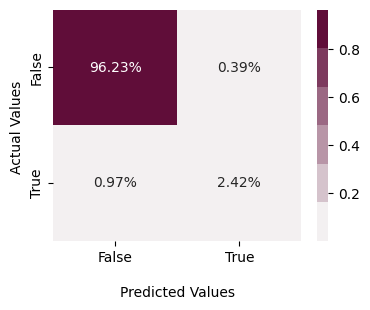

F1-score: 0.7812500000000001
Recall: 0.7142857142857143
Avg meand squared error: 0.32719026006164925
---- Model: Lasso(random_state=0)


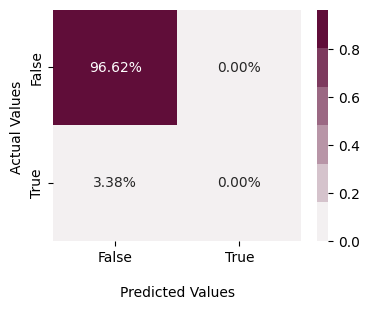

F1-score: 0.0
Recall: 0.0
Avg meand squared error: 1.1966251239647574
---- Model: Ridge(random_state=0)


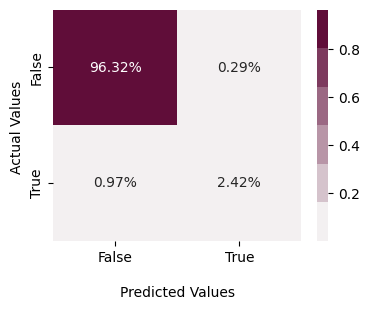

F1-score: 0.7936507936507937
Recall: 0.7142857142857143
Avg meand squared error: 0.32192481463249784
---- Model: SVR()


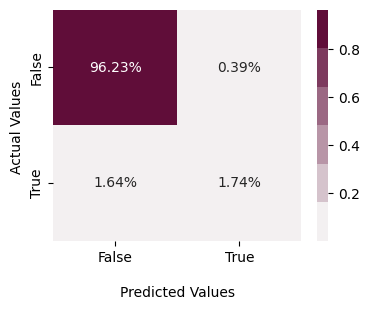

F1-score: 0.6315789473684209
Recall: 0.5142857142857142


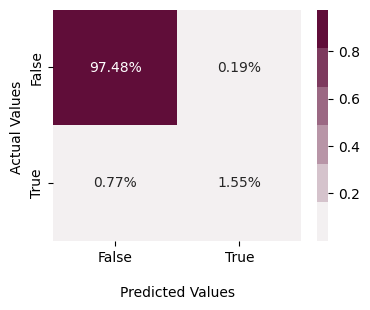

F1-score: 0.761904761904762
Recall: 0.6666666666666666


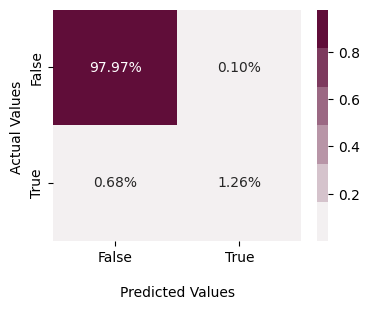

F1-score: 0.7647058823529412
Recall: 0.65
Avg meand squared error: 0.38075228296435837


In [67]:
# build multiple linear regression model
model1 = LinearRegression()
model2 = Lasso(random_state=0)
model3 = Ridge(random_state=0)
model4 = svm.SVR()
MODELS = [model1, model2, model3, model4]

MMS_x_filt, BF1_scores_x_filt = fun.train_kfold_model_selection(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = MODELS)

---- Model: DecisionTreeRegressor(random_state=0)


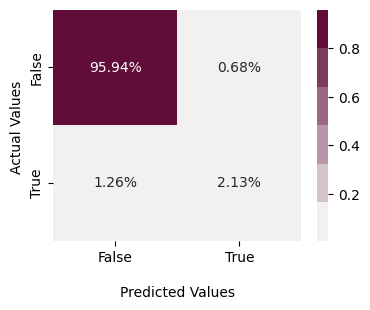

F1-score: 0.6875
Recall: 0.6285714285714286
Avg meand squared error: 0.8553297232633668
---- Model: AdaBoostRegressor(random_state=0)


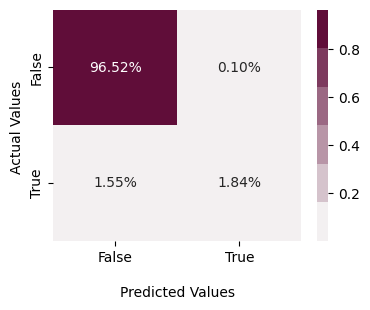

F1-score: 0.6909090909090908
Recall: 0.5428571428571428
Avg meand squared error: 0.4869285876636801
---- Model: BaggingRegressor(random_state=0)


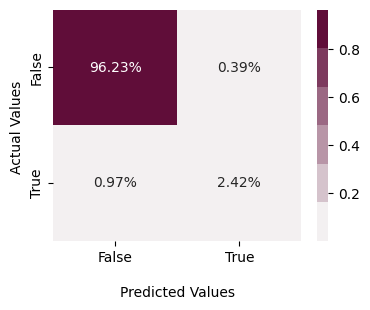

F1-score: 0.7812500000000001
Recall: 0.7142857142857143
Avg meand squared error: 0.4421678784585096
---- Model: RandomForestRegressor(random_state=0)


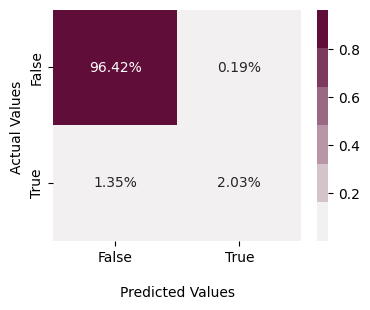

F1-score: 0.7241379310344828
Recall: 0.6
Avg meand squared error: 0.399275652214103


In [68]:
# Second part
model5 = DecisionTreeRegressor(random_state=0)
model6 = AdaBoostRegressor(random_state=0)
model7 = BaggingRegressor(random_state=0)
model8 = RandomForestRegressor(random_state=0)
MODELS = [model5, model6, model7, model8]

MMS_x_filt_2, BF1_scores_x_filt_2 = fun.train_kfold_model_selection(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = MODELS)

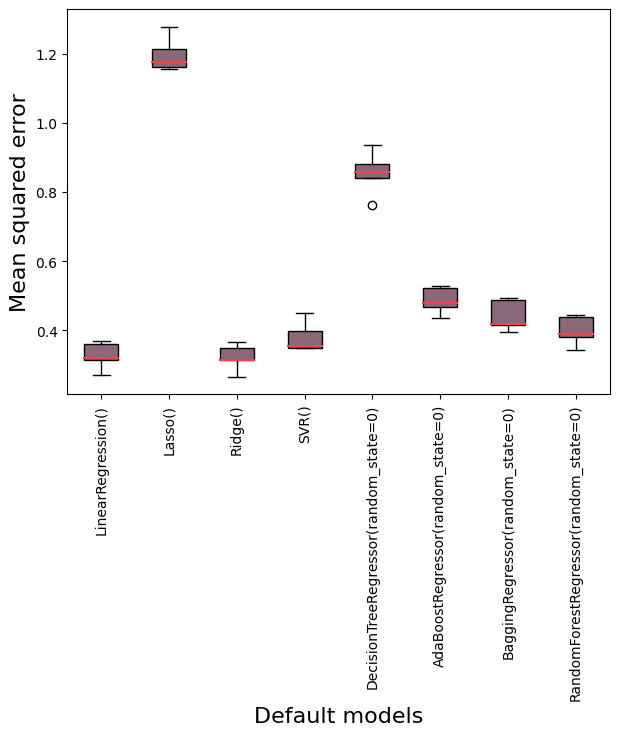

In [70]:
# Showing results
exp1 = list(MMS_x_filt.values())+list(MMS_x_filt_2.values())
medianprops = dict(linestyle='-', linewidth=1.5, color=(.937, .275, .282))
models_name = ['LinearRegression()','Lasso()','Ridge()','SVR()']+[str(model) for model in MODELS] #For labels

fig, ax = plt.subplots(1, 1, figsize=(7,5))
bp = ax.boxplot(exp1,labels=models_name,patch_artist=True, medianprops=medianprops)
#Changing colour of the boxes
for patch, color in zip(bp['boxes'], [(.345, .157, .255, 0.7)]*8):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k')   
ax.set_ylabel('Mean squared error', color="black", fontsize=16)   
ax.set_xlabel('Default models', color="black", fontsize=16)
ax.grid(False)
plt.xticks(rotation=90)
#plt.savefig('repeated_compounds.jpg',bbox_inches='tight', dpi=150)
plt.show()

### 3) Grid search parameter selection

In [71]:
from sklearn.model_selection import GridSearchCV

In [87]:
# Sets for training
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=6752)

In [92]:
# ----------- LINEAR REGRESSION

#Create the grid
grid_vals1 = {'fit_intercept': [True, False]}
grid_lr1 = GridSearchCV(estimator=model1, param_grid=grid_vals1, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result1 = grid_lr1.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result1.best_score_)
print('Best Hyperparameters: %s' % result1.best_params_)

Best Score: -0.3272556118238763
Best Hyperparameters: {'fit_intercept': True}


In [87]:
# ----------- LINEAR REGRESSION WITH RIDGE REGULARIZATION

#Create the grid
grid_vals3 = {'alpha': [0.001,0.01,0.1,1.0,1.1,1.3,1.5], 'fit_intercept': [True, False]}
grid_lr3 = GridSearchCV(estimator=model3, param_grid=grid_vals3, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result = grid_lr3.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.32421705988127103
Best Hyperparameters: {'alpha': 1.3, 'fit_intercept': True}


---- Model: Ridge(alpha=1.3, random_state=0)


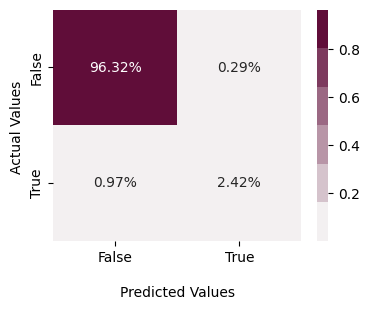

F1-score: 0.7936507936507937
Recall: 0.7142857142857143
Avg meand squared error: 0.32150712324505804


In [89]:
model3_hyp = Ridge(alpha=1.3,fit_intercept = True,random_state=0)
MMS_mod3_hyp, BF1_smod3_hyp = fun.train_kfold_model_selection(X_filtered, y, cv_k, thr, [model3_hyp])

In [95]:
# ----------- SUPPORT VECTOR MACHINES FOR REGRESSION

#Create the grid
grid_vals4 = {'kernel': ["poly", "rbf", "sigmoid"], 'gamma': [1.0, 0.1, 1e-2], 'C': [1, 10, 30, 50, 80, 100]}
grid_lr4 = GridSearchCV(estimator=model4, param_grid=grid_vals4, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result4 = grid_lr4.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result4.best_score_)
print('Best Hyperparameters: %s' % result4.best_params_)

Best Score: -0.5428358825491049
Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [100]:
# ----------- RANDOM FOREST

#Create the grid
grid_vals8 = {'n_estimators': [30,50,100,150,200], 'max_depth': [None,3,5,9,12], 'min_samples_leaf': [1,2,3],'random_state': [0],'n_jobs':[-1]}
grid_lr8 = GridSearchCV(estimator=model8, param_grid=grid_vals8, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result8 = grid_lr8.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result8.best_score_)
print('Best Hyperparameters: %s' % result8.best_params_)

Best Score: -0.41416010398136544
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}


In [106]:
# ----------- DECISION TREE: I will use this as the base estimator for bagging

#Create the grid
grid_vals5 = {'splitter':['best', 'random'], 'min_samples_split':[2,5,7,10], 'max_depth':[None,5,10,15,20], }
grid_lr5 = GridSearchCV(estimator=model5, param_grid=grid_vals5, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result5 = grid_lr5.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result5.best_score_)
print('Best Hyperparameters: %s' % result5.best_params_)

Best Score: -0.5357515860010025
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2, 'splitter': 'best'}


In [110]:
# ----------- BAGGING

#Create the grid
grid_vals7 = {'base_estimator':[result5.best_estimator_],'n_estimators': [10,30,50,70,100], 'max_features':[0.25,0.5,1.0]}
grid_lr7 = GridSearchCV(estimator=model7, param_grid=grid_vals7, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result7 = grid_lr7.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result7.best_score_)
print('Best Hyperparameters: %s' % result7.best_params_)

Best Score: -0.45457888448387607
Best Hyperparameters: {'base_estimator': DecisionTreeRegressor(max_depth=5, random_state=0), 'max_features': 0.5, 'n_estimators': 100}


In [112]:
# ----------- ADABOOST

#Create the grid
grid_vals6 = {'base_estimator':[result5.best_estimator_], 'n_estimators': [10,30,50,70,100], 'learning_rate': [1.5, 1.0, 0.1, 1e-2]}
grid_lr6 = GridSearchCV(estimator=model6, param_grid=grid_vals6, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result6 = grid_lr6.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result6.best_score_)
print('Best Hyperparameters: %s' % result6.best_params_)

Best Score: -0.4233454347654072
Best Hyperparameters: {'base_estimator': DecisionTreeRegressor(max_depth=5, random_state=0), 'learning_rate': 1.0, 'n_estimators': 100}


**Best models comparision**

In [127]:
# Building the models
best_ridge = Ridge(alpha=1.3, random_state=0)
best_svr = svm.SVR(C=10, gamma=0.01)
best_tree = DecisionTreeRegressor(max_depth = 5, random_state=0)
best_rf = RandomForestRegressor(min_samples_leaf = 3, n_estimators = 200, n_jobs=-1,random_state=0)
best_bag = BaggingRegressor(base_estimator = best_tree, max_features = 0.5, n_estimators=100, random_state=0)
best_ada = AdaBoostRegressor(base_estimator = best_tree, n_estimators = 100, random_state=0)

BEST_MODELS = [model1,best_ridge, best_svr, best_tree, best_rf, best_bag, best_ada]

---- Model: LinearRegression()


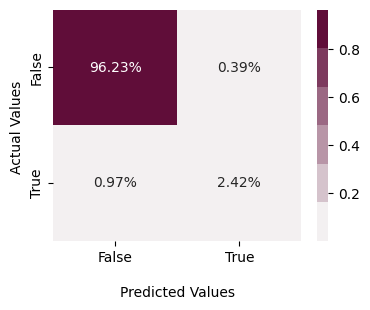

F1-score: 0.7812500000000001
Recall: 0.7142857142857143
Avg meand squared error: 0.32719026006164925
---- Model: Ridge(alpha=1.3, random_state=0)


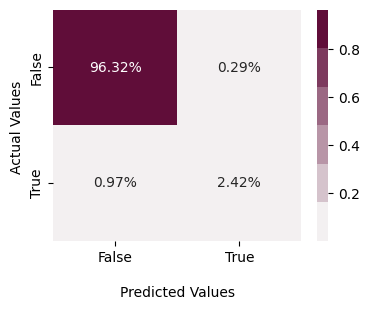

F1-score: 0.7936507936507937
Recall: 0.7142857142857143
Avg meand squared error: 0.32150712324505804
---- Model: SVR(C=10, gamma=0.01)


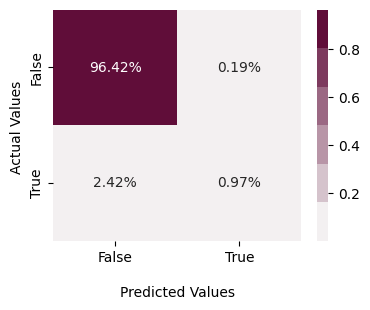

F1-score: 0.42553191489361697
Recall: 0.2857142857142857


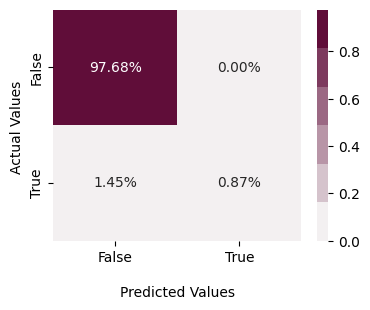

F1-score: 0.5454545454545454
Recall: 0.375


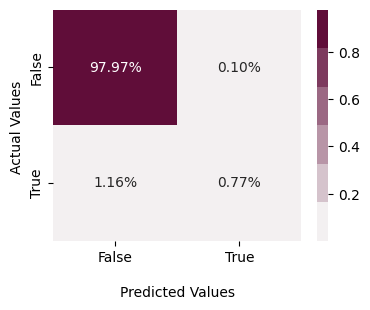

F1-score: 0.5517241379310346
Recall: 0.4
Avg meand squared error: 0.5212653807880142
---- Model: DecisionTreeRegressor(max_depth=5, random_state=0)


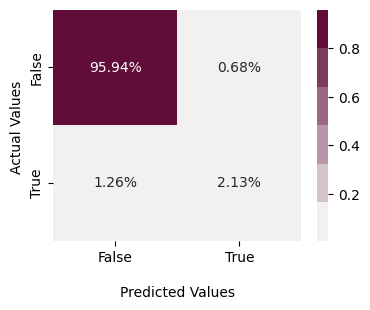

F1-score: 0.6875
Recall: 0.6285714285714286
Avg meand squared error: 0.5109499329678437
---- Model: RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1,
                      random_state=0)


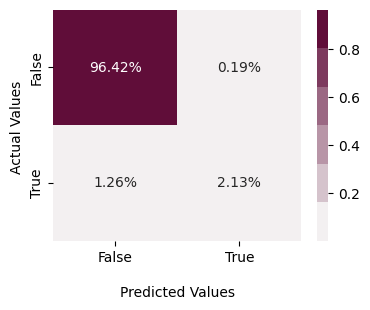

F1-score: 0.7457627118644068
Recall: 0.6285714285714286
Avg meand squared error: 0.39764152162613337
---- Model: BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                      random_state=0),
                 max_features=0.5, n_estimators=100, random_state=0)


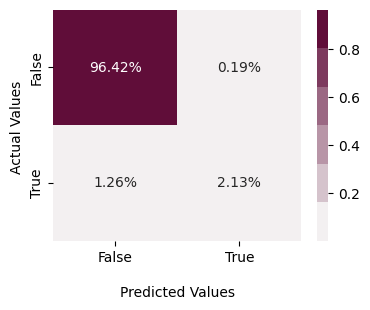

F1-score: 0.7457627118644068
Recall: 0.6285714285714286
Avg meand squared error: 0.44049192763964984
---- Model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=0),
                  n_estimators=100, random_state=0)


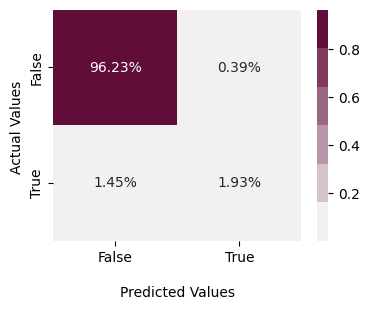

F1-score: 0.6779661016949152
Recall: 0.5714285714285714
Avg meand squared error: 0.42105868637651367


In [128]:
BEST_MODELS = [model1,best_ridge, best_svr, best_tree, best_rf, best_bag, best_ada]

Best_MMS_x_filt, Best_BF1_scores_x_filt = fun.train_kfold_model_selection(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = BEST_MODELS)

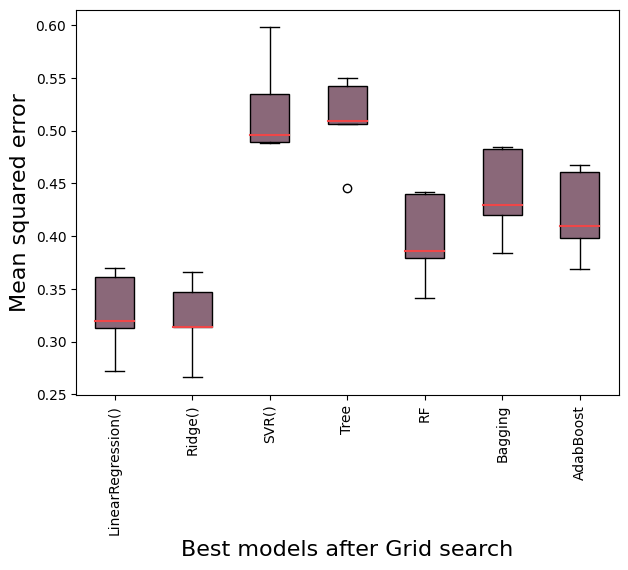

In [129]:
exp1 = list(Best_MMS_x_filt.values())
medianprops = dict(linestyle='-', linewidth=1.5, color=(.937, .275, .282))
models_name = ['LinearRegression()','Ridge()','SVR()','Tree', 'RF', 'Bagging', 'AdabBoost']
fig, ax = plt.subplots(1, 1, figsize=(7,5))
bp = ax.boxplot(exp1,labels=models_name,patch_artist=True, medianprops=medianprops)
#Changing colour
for patch, color in zip(bp['boxes'], [(.345, .157, .255, 0.7)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k')   
ax.set_ylabel('Mean squared error', color="black", fontsize=16)   
ax.set_xlabel('Best models after Grid search', color="black", fontsize=16)
ax.grid(False)
plt.xticks(rotation=90)
#plt.savefig('repeated_compounds.jpg',bbox_inches='tight', dpi=150)
plt.show()

In [140]:
Best_MMS_x_filt_v2, Best_BF1_scores_x_filt_v2 = fun.train_kfold_model_selection_v2(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = BEST_MODELS)

---- Model: LinearRegression()
---- Model: Ridge(alpha=1.3, random_state=0)
---- Model: SVR(C=10, gamma=0.01)
---- Model: DecisionTreeRegressor(max_depth=5, random_state=0)
---- Model: RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1,
                      random_state=0)
---- Model: BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                      random_state=0),
                 max_features=0.5, n_estimators=100, random_state=0)
---- Model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=0),
                  n_estimators=100, random_state=0)


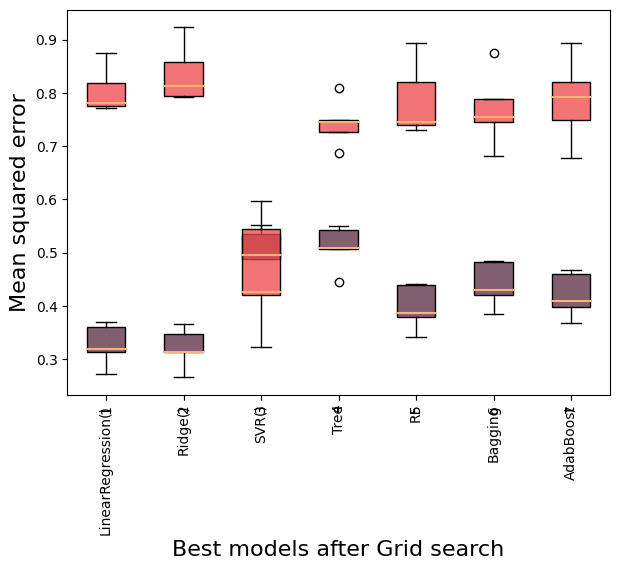

In [143]:
accuracy = list(Best_MMS_x_filt_v2.values())
f1score = list(Best_BF1_scores_x_filt_v2.values())
models_name = ['LinearRegression()','Ridge()','SVR()','Tree', 'RF', 'Bagging', 'AdabBoost']

medianprops = dict(linestyle='-', linewidth=1.5, color=(.98, .702, .447))
fig, ax = plt.subplots(1, 1, figsize=(7,5))
bp0 = ax.boxplot(accuracy, labels = None,patch_artist=True, medianprops = medianprops)
bp1 = ax.boxplot(f1score,labels = models_name, patch_artist=True, medianprops = medianprops)

#Changing colour
for patch, color in zip(bp0['boxes'], [(.345, .157, .255, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 
for patch, color in zip(bp1['boxes'], [(.937, .275, .282, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 

ax.set_ylabel('Mean squared error', color="black", fontsize=16)   
ax.set_xlabel('Best models after Grid search', color="black", fontsize=16)
ax.grid(False)
plt.xticks(rotation=90)

#plt.savefig('repeated_compounds.jpg',bbox_inches='tight', dpi=150)
plt.show()

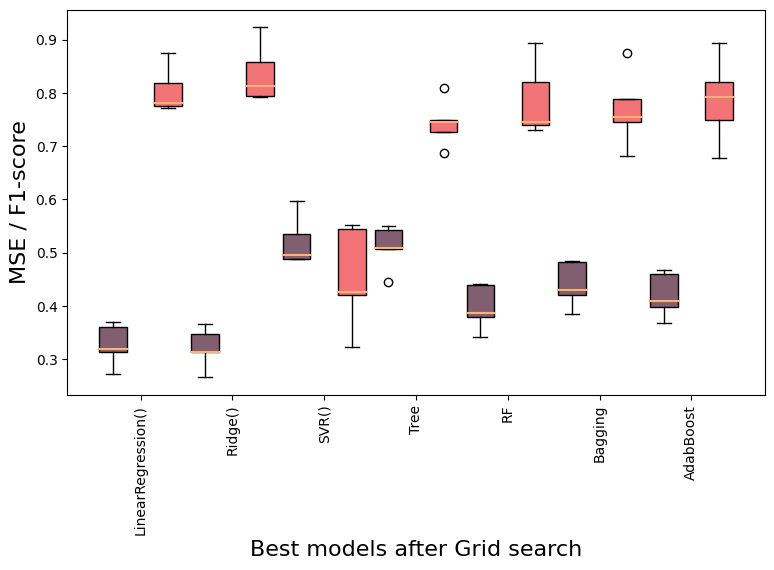

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(9,5))
bp0 = ax.boxplot(accuracy, labels = None, positions = np.arange(np.array(accuracy).shape[0])-0.3, widths = 0.3, patch_artist = True, medianprops = medianprops)
bp1 = ax.boxplot(f1score, labels = None, positions = np.arange(np.array(f1score).shape[0])+0.3, widths = 0.3, patch_artist = True, medianprops = medianprops)

#Changing colour
for patch, color in zip(bp0['boxes'], [(.345, .157, .255, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 
for patch, color in zip(bp1['boxes'], [(.937, .275, .282, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 

ax.set_ylabel('MSE / F1-score', color="black", fontsize=16)   
ax.set_xlabel('Best models after Grid search', color="black", fontsize=16)
ax.grid(False)
plt.xticks(ticks= np.arange(0,7),labels = models_name,rotation=90)

#plt.savefig('repeated_compounds.jpg',bbox_inches='tight', dpi=150)
plt.show()